In [452]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [453]:
import random
import os

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(1234)
    tf.random.set_seed(1234)
    np.random.seed(1234)
    random.seed(1234)

In [454]:
#read csv, print 5 rows
klangapi = pd.read_csv('klangapiCleanedHourly.csv')

#change data type "date" from object to actual date for easy analysis
klangapi['date']=pd.to_datetime(klangapi['date'])
#set index to date
klangapi.set_index('date',inplace=True)
klangapi.drop(['nox'], axis=1, inplace=True)

klangapi

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2002-10-01,1.000,359.0,22.600,89.000,0.0740,0.0090,0.0330,0.0010,3.750,142.000
2002-10-01,1.000,356.0,22.300,90.000,0.0680,0.0100,0.0320,0.0010,3.490,136.000
2002-10-01,1.200,11.0,22.300,90.000,0.0420,0.0070,0.0280,0.0010,2.980,144.000
2002-10-01,0.900,349.0,22.200,90.000,0.0420,0.0050,0.0230,0.0010,2.840,146.000
2002-10-01,0.500,333.0,22.000,92.000,0.0570,0.0060,0.0210,0.0010,2.910,118.000
...,...,...,...,...,...,...,...,...,...,...
2020-12-31,1.772,206.0,28.779,80.241,0.0009,0.0012,0.0077,0.0275,0.562,15.332
2020-12-31,1.374,185.0,28.200,82.533,0.0016,0.0011,0.0161,0.0164,0.620,21.630
2020-12-31,1.243,105.0,27.643,83.318,0.0017,0.0011,0.0220,0.0084,0.925,25.202


In [455]:
trainTest=klangapi.loc['2002-01-01':'2019-12-31'].copy() #2002-2017/3/31
verifyDeploy=klangapi.loc['2020-01-01':'2020-12-31'].copy() #2018
jumlahTrainNTest=trainTest.shape[0]
jumlahVerification=verifyDeploy.shape[0]
print(jumlahTrainNTest,jumlahVerification,jumlahTrainNTest+jumlahVerification)

144924 8784 153708


In [456]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# scaler = StandardScaler()
# scaler = scaler.fit(klangapi)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(klangapi)
trainTestScaled = scaler.transform(trainTest)
verifyDeployScaled = scaler.transform(verifyDeploy)
trainTestScaled.shape,verifyDeployScaled.shape

((144924, 10), (8784, 10))

## THIS SEGMENT IS TO CHECK THE DATA

In [457]:
trainTest.iloc[[-1]]

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2019-12-31,0.409,118.0,25.235,94.817,0.0871,0.0016,0.027,0.0007,3.799,52.226


In [458]:
scaler.inverse_transform(trainTestScaled[[-1]])[0][9]


52.226

In [459]:
verifyDeploy.iloc[[0]]

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2020-01-01,0.567,121.0,25.839,93.05,0.0939,0.0018,0.0272,0.0006,3.875,93.162


In [460]:
scaler.inverse_transform(verifyDeployScaled[[0]])[0][9]

93.162

In [461]:
##splitting dataset into train and test split
training_size=int(len(trainTestScaled)*0.80)
test_size=len(trainTestScaled)-training_size
train,test=trainTestScaled[0:training_size,:],trainTestScaled[training_size:len(trainTestScaled),:]

train.shape,test.shape

((115939, 10), (28985, 10))

## END OF SEGMENT

In [462]:
# references target features
# 10 = pm10
# 9 = co
# 8 = o3
# 7 = no2
# 6 = so2
# 5 = no
# 4 = nox

In [463]:
# function to organize data in correct forms so that the data can be fitted to the model
# data, number of past days, number of features, target pollutants to be predicted
def to_sequences(dataset, n_past, no_features, target_features):
    # n_past: Number of past days we want to use to predict the future.
    X = []
    y = []
    n_future = 24   # Number of days we want to look into the future based on the past days.
    for i in range(n_past, len(dataset) - n_future+1):
        X.append(dataset[i - n_past:i, 0:no_features])
        y.append(dataset[i + n_future - 1:i + n_future, target_features]) 
    return np.array(X), np.array(y)

# function to build LSTM model
def modelling(no_past, no_features):
    reset_random_seeds()
    model = Sequential()
    model.add(GRU(32, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))
#     model.add(LSTM(64, return_sequences=False))
#     model.add(Dense(32))
    # model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))

    model.compile(Adam(learning_rate=0.001), loss='mse')
    return model
    #model.summary()#ANN->RNN->LSTM
    
# function to retrieve performance of the model
def performance_measure(actual,pred) :
    rmse=math.sqrt(mean_squared_error(actual,pred, squared=False))
    mae=mean_absolute_error(actual, pred)
    mape=mean_absolute_percentage_error(actual, pred)*100
    return rmse,mae,mape


In [66]:
import keras_tuner as kt
reset_random_seeds()

def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        hp.Choice('units', [64, 128, 256 ,512]),
        hp.Choice("activation", ["relu", "tanh"])))
    model.add(Dropout(0.2))
    model.add(Dense(trainY.shape[1]))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.0001,0.001,0.01,0.1] )), loss='mse')
    return model
                                
tuner = kt.Hyperband(build_model, # the hypermodel
                     objective='val_loss', # objective to optimize
                     max_epochs=20,
                     factor=3, # factor which you have seen above 
                     directory='logsLSTMHourly', # directory to save logs 
                     project_name='hypertuning')
                                 
# tuner.search_space_summary()
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# # Perform hypertuning
# tuner.search(trainX, trainY, epochs=20, batch_size=72, validation_data=(testX,testY), verbose=1, callbacks=[stop_early])


Trial 31 Complete [02h 01m 42s]
val_loss: 0.00040195524343289435

Best val_loss So Far: 0.00042986078187823296
Total elapsed time: 10h 29m 21s
INFO:tensorflow:Oracle triggered exit


In [67]:
#pm10
hp=tuner.get_best_hyperparameters()[0]
print(hp.Choice('units', [32, 64, 128]))
print(hp.Choice('learning_rate', [0.0001,0.001,0.01,0.1]))
print(hp.Choice('activation', [0.0001,0.001,0.01,0.1]))

64
0.1
tanh


# PM10 Modelling : 9

### Restrustured the data and determine the target features

In [341]:
trainX, trainY = to_sequences(train, 72, klangapi.shape[1],9)
testX, testY = to_sequences(test, 72, klangapi.shape[1],9)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115844, 72, 10).
trainY shape == (115844, 1).
testX shape == (28890, 72, 10).
testY shape == (28890, 1).


In [342]:
trainTestScaled[0:73]

array([[0.04950495, 0.99722222, 0.14054054, 0.8625    , 0.24706649,
        0.08035714, 0.25984252, 0.00787402, 0.2417795 , 0.09693186],
       [0.04950495, 0.98888889, 0.12432432, 0.875     , 0.22750978,
        0.08928571, 0.2519685 , 0.00787402, 0.22501612, 0.09280192],
       [0.05940594, 0.03055556, 0.12432432, 0.875     , 0.14276402,
        0.0625    , 0.22047244, 0.00787402, 0.19213411, 0.09830851],
       [0.04455446, 0.96944444, 0.11891892, 0.875     , 0.14276402,
        0.04464286, 0.18110236, 0.00787402, 0.18310767, 0.09968516],
       [0.02475248, 0.925     , 0.10810811, 0.9       , 0.1916558 ,
        0.05357143, 0.16535433, 0.00787402, 0.18762089, 0.08041209],
       [0.04455446, 0.98333333, 0.11351351, 0.9       , 0.17535854,
        0.03571429, 0.1496063 , 0.00787402, 0.18762089, 0.08316538],
       [0.03960396, 0.24166667, 0.11351351, 0.9       , 0.42633638,
        0.08928571, 0.18110236, 0.01574803, 0.23791103, 0.09280192],
       [0.05445545, 0.06944444, 0.1459459

In [343]:
trainY[1][0]

0.1003734846545026

In [344]:
trainY[1][0] == trainTestScaled[96][9]

True

### Training model

In [345]:
#trainX(number of rows, number of past days, number of features)
#PM10 Modelling
modelPM10=modelling(trainX.shape[1],trainX.shape[2]) 
modelPM10.summary()
history = modelPM10.fit(trainX, trainY, epochs=10, batch_size=8, validation_data=(testX,testY), verbose=1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
14481/14481 [==============================] - 121s 8ms/step - loss: 7.8653e-04 - val_loss: 4.2559e-04
Epoch 2/10
14481/14481 [==============================] - 121s 8ms/step - loss: 7.0613e-04 - val_loss: 5.0518e-04
Epoch 3/10
14481/14481 [==============================] - 129s 9ms/step - loss: 6.9337e-04 - val_loss: 5.2492e-04
Epoch 4/10
14481/14481 [=============

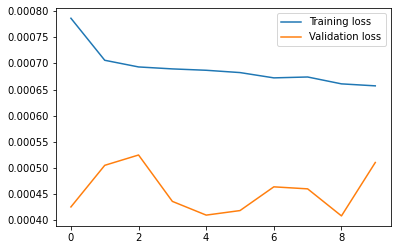

In [346]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [347]:
prediction = modelPM10.predict(trainX)


In [348]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,9]


In [349]:
y_pred_future

array([92.809975, 89.845215, 90.60473 , ..., 52.179417, 53.008965,
       56.799873], dtype=float32)

In [350]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,9]
#klangapi.iloc[3:4831,10]

In [351]:
trainTest.iloc[0:97]

,wind_speed,wind_direction,temperature,relative_humidity,no,so2,no2,o3,co,pm10
date,,,,,,,,,,
2002-10-01,1.0,359.0,22.6,89.0,0.074,0.009,0.033,0.001,3.75,142.0
2002-10-01,1.0,356.0,22.3,90.0,0.068,0.010,0.032,0.001,3.49,136.0
2002-10-01,1.2,11.0,22.3,90.0,0.042,0.007,0.028,0.001,2.98,144.0
2002-10-01,0.9,349.0,22.2,90.0,0.042,0.005,0.023,0.001,2.84,146.0
2002-10-01,0.5,333.0,22.0,92.0,0.057,0.006,0.021,0.001,2.91,118.0
...,...,...,...,...,...,...,...,...,...,...
2002-10-04,2.6,48.0,26.3,80.0,0.027,0.006,0.040,0.015,2.25,94.0
2002-10-04,3.0,27.0,25.8,84.0,0.075,0.010,0.049,0.005,3.99,172.0
2002-10-04,2.3,15.0,25.4,85.0,0.107,0.015,0.048,0.005,4.85,179.0


In [352]:
actualY

array([184., 147., 156., ...,  34.,  31.,  31.])

In [353]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 6.064944588481161.
MAE : 24.183651800314237.
MAPE : 52.34588075623925.


In [354]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
train_results


,Train Predictions,Actuals
0,92.809975,184.0
1,89.845215,147.0
2,90.604729,156.0
3,93.968040,156.0
4,91.484146,143.0
...,...,...
115839,53.034191,45.0
115840,52.603851,34.0
115841,52.179417,34.0
115842,53.008965,31.0


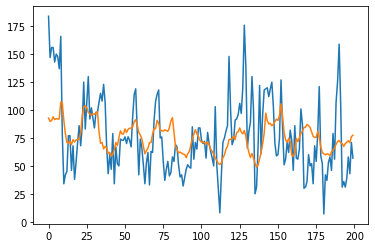

In [355]:
plt.plot(train_results['Actuals'][0:200])
plt.plot(train_results['Train Predictions'][0:200])


### Deploy on unseen data 2020


In [356]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 48, klangapi.shape[1],9)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (8713, 48, 10).
verifyY shape == (8713, 1).


In [357]:
prediction = modelPM10.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,9]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,9]

In [358]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 5.392288089046661.
MAE : 25.926522791500346.
MAPE : 121.79023667543541.


In [359]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results


,Train Predictions,Actuals
0,58.037342,24.327
1,58.901382,21.103
2,58.379440,20.231
3,61.413597,27.376
4,60.225990,36.652
...,...,...
8708,55.214142,15.332
8709,62.331661,21.630
8710,64.771797,25.202
8711,66.120491,29.169


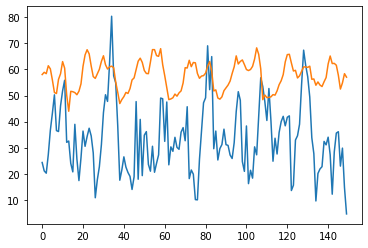

In [360]:
plt.plot(test_results['Actuals'][0:150])
plt.plot(test_results['Train Predictions'][0:150])


# CO Modelling : 8

In [361]:
trainX, trainY = to_sequences(train, 72, klangapi.shape[1], 8)
testX, testY = to_sequences(test, 72, klangapi.shape[1], 8)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115844, 72, 10).
trainY shape == (115844, 1).
testX shape == (28890, 72, 10).
testY shape == (28890, 1).


In [362]:
trainY[0][0] == trainTestScaled[3][9]

False

In [363]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [364]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0020 - val_loss: 7.6950e-04
Epoch 2/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0019 - val_loss: 9.0295e-04
Epoch 3/20
14481/14481 [==============================] - 136s 9ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 4/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0018 - val_loss: 8.0375e-04
Epoch 5/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0018 - val_loss: 7.5326e-04
Epoch 6/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0018 - val_loss: 7.2284e-04
Epoch 7/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0018 - val_loss: 8.3949e-04
Epoch 8/20
14481/14481 [==============================] - 134s 9ms/step - loss: 0.0017 - val_loss: 7.9241e-04
Epoch 9/20
14481/14481 [==============================] - 133s 9ms/step - loss: 0.0017 - val_loss: 7.3547e-04
Epoch 10/20
14

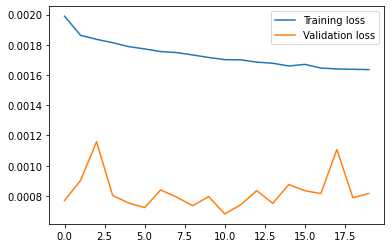

In [365]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [366]:
prediction = model.predict(trainX)

In [367]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,8]
y_pred_future.shape

(115844,)

In [368]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,8]
actualY.shape

(115844,)

In [369]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.807917869562733.
MAE : 0.43515352903622534.
MAPE : 147115890382718.38.


In [370]:
train_results

,Train Predictions,Actuals
0,92.809975,184.0
1,89.845215,147.0
2,90.604729,156.0
3,93.968040,156.0
4,91.484146,143.0
...,...,...
115839,53.034191,45.0
115840,52.603851,34.0
115841,52.179417,34.0
115842,53.008965,31.0


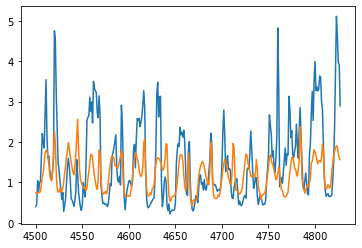

In [371]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Actuals'][4500:4828])
plt.plot(train_results['Train Predictions'][4500:4828])


### Deploy on unseen data


In [372]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 72, klangapi.shape[1], 8)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (8689, 72, 10).
verifyY shape == (8689, 1).


In [373]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,8]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,8]

In [374]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.6671234450976427.
MAE : 0.364217567875756.
MAPE : 60.873537890960804.


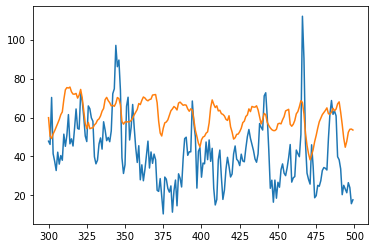

In [375]:
plt.plot(test_results['Actuals'][300:500])
plt.plot(test_results['Train Predictions'][300:500])


In [376]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,1.414714,0.910
1,1.370939,0.887
2,1.309272,0.756
3,1.229850,0.585
4,1.183759,0.692
...,...,...
8684,1.185844,0.562
8685,1.401877,0.620
8686,1.533569,0.925
8687,1.608209,1.166


# O3 Modelling : 7

In [377]:
trainX, trainY = to_sequences(train, 72, klangapi.shape[1], 7)
testX, testY = to_sequences(test, 72, klangapi.shape[1], 7)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115844, 72, 10).
trainY shape == (115844, 1).
testX shape == (28890, 72, 10).
testY shape == (28890, 1).


In [378]:
trainY[0][0] == trainTestScaled[3][7]

False

In [379]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [380]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
14481/14481 [==============================] - 142s 10ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 2/20
14481/14481 [==============================] - 165s 11ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 3/20
14481/14481 [==============================] - 174s 12ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 4/20
14481/14481 [==============================] - 156s 11ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 5/20
14481/14481 [==============================] - 174s 12ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/20
14481/14481 [==============================] - 170s 12ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 7/20
14481/14481 [==============================] - 163s 11ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 8/20
14481/14481 [==============================] - 163s 11ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 9/20
14481/14481 [==============================] - 162s 11ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 10/20
14481/14481 [============

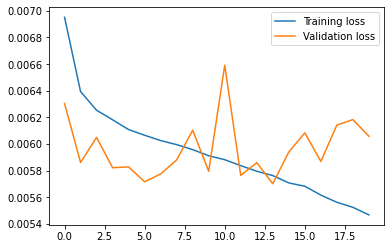

In [381]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [382]:
prediction = model.predict(trainX)

In [383]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,7]
y_pred_future.shape

(115844,)

In [384]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,7]
actualY.shape

(115844,)

In [385]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.0964326651025325.
MAE : 0.006344358785462265.
MAPE : 39433568654143.74.


In [386]:
train_results

,Train Predictions,Actuals
0,2.044697,3.86
1,2.020671,4.11
2,1.847489,3.28
3,1.690067,2.94
4,1.596604,3.22
...,...,...
115839,0.498639,0.37
115840,0.569050,0.34
115841,0.603107,0.38
115842,0.743548,0.49


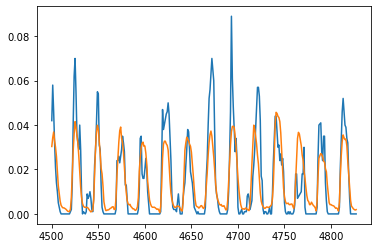

In [387]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Actuals'][4500:4828])
plt.plot(train_results['Train Predictions'][4500:4828])


### Deploy on unseen data


In [388]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 72, klangapi.shape[1], 7)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (8689, 72, 10).
verifyY shape == (8689, 1).


In [389]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,7]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,7]

In [390]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.09377561677564437.
MAE : 0.0062778690092101935.
MAPE : 114.51688139193972.


In [391]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.002446,0.0080
1,0.002696,0.0079
2,0.002902,0.0063
3,0.002593,0.0075
4,0.001907,0.0090
...,...,...
8684,0.018772,0.0275
8685,0.012869,0.0164
8686,0.008269,0.0084
8687,0.005256,0.0036


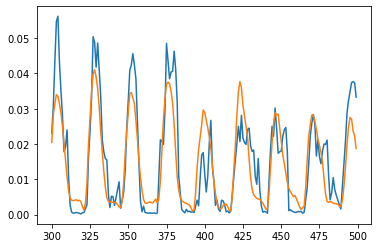

In [392]:
plt.plot(test_results['Actuals'][300:500])
plt.plot(test_results['Train Predictions'][300:500])


# NO2 Modelling : 6

In [393]:
trainX, trainY = to_sequences(train, 72, klangapi.shape[1], 6)
testX, testY = to_sequences(test, 72, klangapi.shape[1], 6)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115844, 72, 10).
trainY shape == (115844, 1).
testX shape == (28890, 72, 10).
testY shape == (28890, 1).


In [394]:
trainY[0][0] == trainTestScaled[3][6]

False

In [395]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
14481/14481 [==============================] - 168s 12ms/step - loss: 0.0062 - val_loss: 0.0042
Epoch 2/20
14481/14481 [==============================] - 171s 12ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 3/20
14481/14481 [==============================] - 171s 12ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 4/20
14481/14481 [==============================] - 

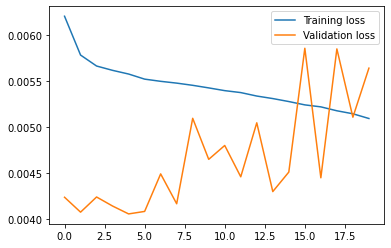

In [396]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [397]:
prediction = model.predict(trainX)

In [398]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,6]
y_pred_future.shape

(115844,)

In [399]:
# y_pred_future=np.round_(y_pred_future, decimals = 4)

In [400]:
y_pred_future

array([0.04077436, 0.03881147, 0.03503543, ..., 0.0166519 , 0.02150245,
       0.02602219], dtype=float32)

In [401]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,6]
actualY.shape

(115844,)

In [402]:
actualY

array([0.047, 0.058, 0.043, ..., 0.012, 0.012, 0.014])

In [403]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.09481603490602478.
MAE : 0.006940206924397968.
MAPE : 13544600558624.83.


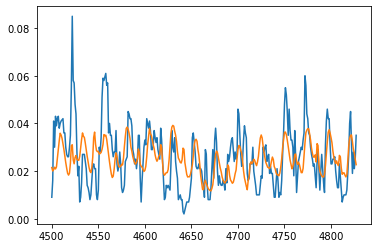

In [404]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Actuals'][4500:4828])
plt.plot(train_results['Train Predictions'][4500:4828])


In [405]:
train_results

,Train Predictions,Actuals
0,0.040774,0.047
1,0.038811,0.058
2,0.035035,0.043
3,0.032384,0.039
4,0.029260,0.038
...,...,...
115839,0.013607,0.009
115840,0.013859,0.009
115841,0.016652,0.012
115842,0.021502,0.012


In [406]:
# klangapi.loc['2015-04-24':'2015-06-30']['no2'].plot()

### Deploy on unseen data


In [407]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 72, klangapi.shape[1], 6)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (8689, 72, 10).
verifyY shape == (8689, 1).


In [408]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,6]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,6]

In [409]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.10471324589846362.
MAE : 0.009404681671470645.
MAPE : 125.40866224713328.


In [410]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.026160,0.0247
1,0.023243,0.0201
2,0.020552,0.0144
3,0.018789,0.0131
4,0.017576,0.0109
...,...,...
8684,0.032287,0.0077
8685,0.034921,0.0161
8686,0.035970,0.0220
8687,0.035576,0.0278


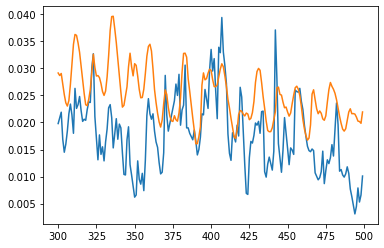

In [411]:
plt.plot(test_results['Actuals'][300:500])
plt.plot(test_results['Train Predictions'][300:500])


# SO2 Modelling : 5

In [412]:
trainX, trainY = to_sequences(train, 72, klangapi.shape[1], 5)
testX, testY = to_sequences(test, 72, klangapi.shape[1], 5)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115844, 72, 10).
trainY shape == (115844, 1).
testX shape == (28890, 72, 10).
testY shape == (28890, 1).


In [413]:
trainY[0][0] == trainTestScaled[3][5]

False

In [414]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [415]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
14481/14481 [==============================] - 142s 10ms/step - loss: 0.0019 - val_loss: 7.2565e-04
Epoch 2/20
14481/14481 [==============================] - 141s 10ms/step - loss: 0.0018 - val_loss: 9.3060e-04
Epoch 3/20
14481/14481 [==============================] - 155s 11ms/step - loss: 0.0018 - val_loss: 8.0505e-04
Epoch 4/20
14481/14481 [==============================] - 152s 10ms/step - loss: 0.0018 - val_loss: 7.2855e-04
Epoch 5/20
14481/14481 [==============================] - 153s 11ms/step - loss: 0.0018 - val_loss: 8.3709e-04
Epoch 6/20
14481/14481 [==============================] - 146s 10ms/step - loss: 0.0017 - val_loss: 7.4694e-04
Epoch 7/20
14481/14481 [==============================] - 144s 10ms/step - loss: 0.0017 - val_loss: 7.5132e-04
Epoch 8/20
14481/14481 [==============================] - 152s 10ms/step - loss: 0.0017 - val_loss: 7.4749e-04
Epoch 9/20
14481/14481 [==============================] - 148s 10ms/step - loss: 0.0017 - val_loss: 8.9843e-04
E

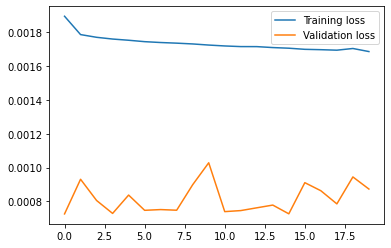

In [416]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [417]:
prediction = model.predict(trainX)

In [418]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,5]
y_pred_future.shape

(115844,)

In [419]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,5]
actualY.shape

(115844,)

In [420]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.06748481526109366.
MAE : 0.002589050580349194.
MAPE : 34715793092247.016.


In [421]:
train_results

,Train Predictions,Actuals
0,0.040774,0.047
1,0.038811,0.058
2,0.035035,0.043
3,0.032384,0.039
4,0.029260,0.038
...,...,...
115839,0.013607,0.009
115840,0.013859,0.009
115841,0.016652,0.012
115842,0.021502,0.012


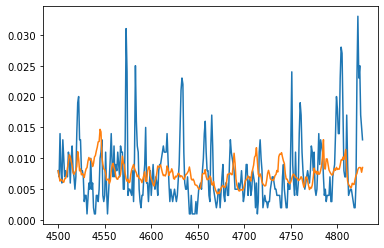

In [422]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Actuals'][4500:4828])
plt.plot(train_results['Train Predictions'][4500:4828])


### Deploy on unseen data


In [423]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 72, klangapi.shape[1], 5)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (8689, 72, 10).
verifyY shape == (8689, 1).


In [424]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,5]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,5]

In [425]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.051742418987131986.
MAE : 0.0024476142885781894.
MAPE : 2607060667278.2456.


In [426]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.003031,0.0005
1,0.002896,0.0004
2,0.002795,0.0006
3,0.002807,0.0005
4,0.002796,0.0006
...,...,...
8684,0.003859,0.0012
8685,0.003907,0.0011
8686,0.003792,0.0011
8687,0.003598,0.0012


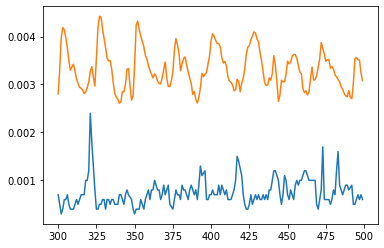

In [427]:
plt.plot(test_results['Actuals'][300:500])
plt.plot(test_results['Train Predictions'][300:500])


# NO Modelling : 4

In [428]:
trainX, trainY = to_sequences(train, 72, klangapi.shape[1], 4)
testX, testY = to_sequences(test, 72, klangapi.shape[1], 4)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115844, 72, 10).
trainY shape == (115844, 1).
testX shape == (28890, 72, 10).
testY shape == (28890, 1).


In [451]:
trainY[0][0] == trainTestScaled[97][4]

False

In [430]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [431]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
14481/14481 [==============================] - 147s 10ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 2/20
14481/14481 [==============================] - 149s 10ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 3/20
14481/14481 [==============================] - 146s 10ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 4/20
14481/14481 [==============================] - 152s 10ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 5/20
14481/14481 [==============================] - 145s 10ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 6/20
14481/14481 [==============================] - 145s 10ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 7/20
14481/14481 [==============================] - 145s 10ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 8/20
14481/14481 [==============================] - 148s 10ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 9/20
14481/14481 [==============================] - 144s 10ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 10/20
14481/14481 [============

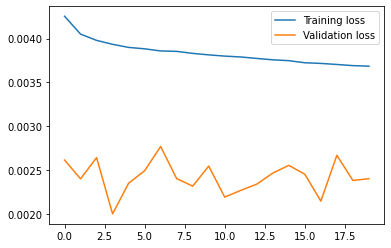

In [432]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [433]:
prediction = model.predict(trainX)

In [434]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
y_pred_future.shape

(115844,)

In [435]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,4]
actualY.shape

(115844,)

In [436]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.13606846752757715.
MAE : 0.012309796123692693.
MAPE : 355749650536022.8.


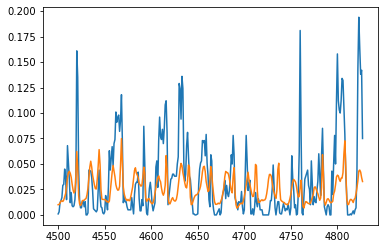

In [437]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Actuals'][4500:4828])
plt.plot(train_results['Train Predictions'][4500:4828])


In [438]:
train_results

,Train Predictions,Actuals
0,0.040709,0.074
1,0.037644,0.081
2,0.033094,0.063
3,0.027628,0.062
4,0.023010,0.071
...,...,...
115839,0.009842,0.009
115840,0.009596,0.006
115841,0.008864,0.008
115842,0.009810,0.008


### Deploy on unseen data


In [439]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 72, klangapi.shape[1], 4)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (8689, 72, 10).
verifyY shape == (8689, 1).


In [440]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,4]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,4]

In [441]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.12689268350127828.
MAE : 0.013839997456433936.
MAPE : 6627970721379.904.


In [442]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.030528,0.0032
1,0.030020,0.0019
2,0.028783,0.0016
3,0.026688,0.0008
4,0.022992,0.0017
...,...,...
8684,0.014633,0.0009
8685,0.018668,0.0016
8686,0.022668,0.0017
8687,0.027385,0.0075


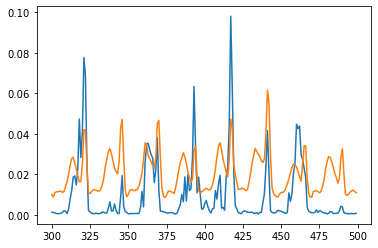

In [443]:
plt.plot(test_results['Actuals'][300:500])
plt.plot(test_results['Train Predictions'][300:500])


# NOX Modelling : 4

In [444]:
trainX, trainY = to_sequences(train, 3, klangapi.shape[1], 4)
testX, testY = to_sequences(test, 3, klangapi.shape[1], 4)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (115913, 3, 10).
trainY shape == (115913, 1).
testX shape == (28959, 3, 10).
testY shape == (28959, 1).


In [445]:
trainY[0][0] == trainTestScaled[3][4]

False

In [809]:
#trainX(number of rows, number of past days, number of features)
#CO Modelling
model=modelling(trainX.shape[1],trainX.shape[2]) 
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 3, 128)            71680     
_________________________________________________________________
lstm_94 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_69 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_37 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 33        
Total params: 123,201
Trainable params: 123,201
Non-trainable params: 0
_________________________________________________________________


In [810]:
history = model.fit(trainX, trainY, epochs=20, batch_size=8, validation_data=(testX,testY), verbose=1)

Epoch 1/20
604/604 [==============================] - 2s 3ms/step - loss: 0.0132 - val_loss: 0.0074
Epoch 2/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 3/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0108 - val_loss: 0.0066
Epoch 4/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0107 - val_loss: 0.0166
Epoch 5/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 6/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0124
Epoch 7/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0078
Epoch 8/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0069
Epoch 9/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0131
Epoch 10/20
604/604 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0102

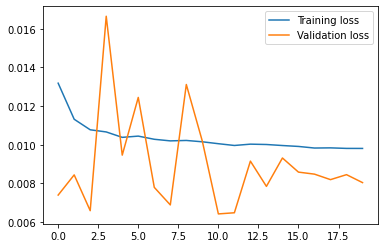

In [811]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [812]:
prediction = model.predict(trainX)

In [813]:
prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,4]
y_pred_future.shape

(4828,)

In [814]:
actualY = np.repeat(trainY, klangapi.shape[1], axis=-1)
actualY = scaler.inverse_transform(actualY)[:,4]
actualY.shape

(4828,)

In [815]:
rmse, mae, mape = performance_measure(actualY,y_pred_future)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.10875208988576765.
MAE : 0.009238024539310198.
MAPE : 27.41612345088797.


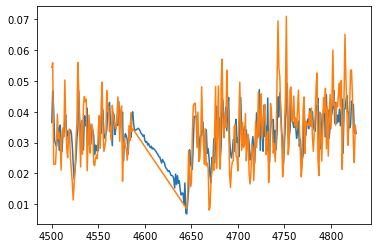

In [816]:
train_results = pd.DataFrame(data={'Train Predictions':y_pred_future, 'Actuals':actualY})
plt.plot(train_results['Train Predictions'][4500:4828])
plt.plot(train_results['Actuals'][4500:4828])

In [817]:
train_results

,Train Predictions,Actuals
0,0.054375,0.0871
1,0.060227,0.0539
2,0.040846,0.0471
3,0.051442,0.0737
4,0.056502,0.0258
...,...,...
4823,0.040809,0.0450
4824,0.042433,0.0295
4825,0.033219,0.0235
4826,0.033165,0.0357


### Deploy on unseen data


In [818]:
verifyX, verifyY = to_sequences(verifyDeployScaled, 3, klangapi.shape[1], 4)
print('verifyX shape == {}.'.format(verifyX.shape))
print('verifyY shape == {}.'.format(verifyY.shape))

verifyX shape == (363, 3, 11).
verifyY shape == (363, 1).


In [819]:
prediction = model.predict(verifyX)

prediction_copies = np.repeat(prediction, klangapi.shape[1], axis=-1)
y_pred_future_test = scaler.inverse_transform(prediction_copies)[:,4]

verificationYRepeat = np.repeat(verifyY, klangapi.shape[1], axis=-1)
verificationYUnscaled = scaler.inverse_transform(verificationYRepeat)[:,4]

In [820]:
rmse, mae, mape = performance_measure(verificationYUnscaled,y_pred_future_test)
print('RMSE : {}.'.format(rmse))
print('MAE : {}.'.format(mae))
print('MAPE : {}.'.format(mape))

RMSE : 0.11382817664430794.
MAE : 0.011521334007751842.
MAPE : 66.49709193013847.


In [821]:
test_results = pd.DataFrame(data={'Train Predictions':y_pred_future_test, 'Actuals':verificationYUnscaled})
test_results

,Train Predictions,Actuals
0,0.041384,0.0245
1,0.034832,0.0220
2,0.032534,0.0241
3,0.033611,0.0313
4,0.036143,0.0271
...,...,...
358,0.035448,0.0158
359,0.034447,0.0281
360,0.038519,0.0247
361,0.038709,0.0354


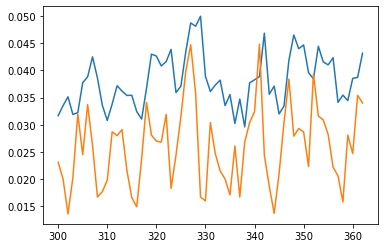

In [822]:
plt.plot(test_results['Train Predictions'][300:])
plt.plot(test_results['Actuals'][300:])

In [ ]:
#no2 so2
#train data mape 20-30
#data 2020 mape 40>

In [ ]:
#hourly data
#data 2019-2020 removed
#training march 2017
#verify 2018
#1,2,3